<a href="https://colab.research.google.com/github/keehyun2/TestPy/blob/master/colab/5-3-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 트리의 앙상블

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/5-3.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

## 랜덤포레스트

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

wine = pd.read_csv('https://bit.ly/wine_csv_data')

data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9973541965122431 0.8905151032797809


In [3]:
rf.fit(train_input, train_target)
print(rf.feature_importances_)

[0.23167441 0.50039841 0.26792718]


Text(0.5, 1.0, 'Random Forest Feature Importances')

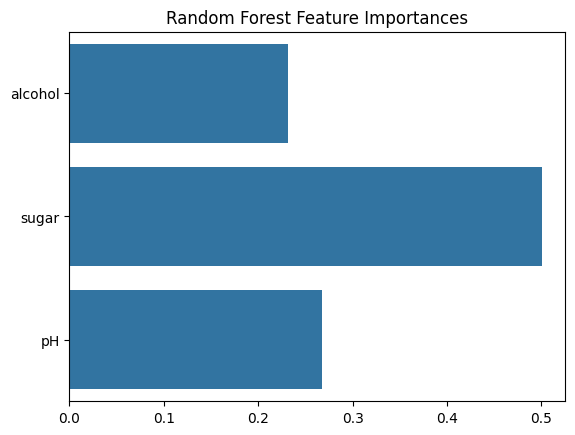

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 특성 중요도 시각화
sns.barplot(x=rf.feature_importances_, y=['alcohol', 'sugar', 'pH'])
plt.title('Random Forest Feature Importances')

In [5]:
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)

rf.fit(train_input, train_target)
print(rf.oob_score_)

0.8934000384837406


## 엑스트라트리

In [6]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(et, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9974503966084433 0.8887848893166506


In [7]:
et.fit(train_input, train_target)
print(et.feature_importances_)

[0.20183568 0.52242907 0.27573525]


## 그레이디언트 부스팅

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8881086892152563 0.8720430147331015


In [9]:
gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.2, random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9464595437171814 0.8780082549788999


In [10]:
gb.fit(train_input, train_target)
print(gb.feature_importances_)

[0.15887763 0.6799705  0.16115187]


## 히스토그램 기반 부스팅

In [11]:
# 사이킷런 1.0 버전 아래에서는 다음 라인의 주석을 해제하고 실행하세요.
# from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9321723946453317 0.8801241948619236


In [12]:
from sklearn.inspection import permutation_importance

hgb.fit(train_input, train_target)
result = permutation_importance(hgb, train_input, train_target, n_repeats=10,
                                random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.08876275 0.23438522 0.08027708]


In [13]:
result = permutation_importance(hgb, test_input, test_target, n_repeats=10,
                                random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.05969231 0.20238462 0.049     ]


In [14]:
hgb.score(test_input, test_target)

0.8723076923076923

#### XGBoost

In [15]:
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='hist', random_state=42)
scores = cross_validate(xgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9558403027491312 0.8782000074035686


#### LightGBM

In [16]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)
scores = cross_validate(lgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.935828414851749 0.8801251203079884
